In [1]:
from typing import Optional, Any, Tuple

import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

from mlxtend.frequent_patterns import apriori, association_rules

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Helper Functions <br>
(We can put them in a separate file and import them, but for now, I just put them here)

In [2]:
def correlation_matrix_for_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Finds the correlation matrix of the dataframe for the missing values
    
    :param df: dataframe
    :return: correlation matrix of the dataframe
    """
    df_copy = df.copy()
    
    df_copy.replace(pd.NA, None, inplace=True)
    df_copy.replace('NaN', None, inplace=True)
    
    heatmap_plot = msno.heatmap(df_copy)
    plt.title('Correlation Between Missing Values', fontsize=30)
    
    return heatmap_plot    


def calculate_rule_support(df: pd.DataFrame, body_and_head_values: dict[str, str]) -> float:
    """
    Calculates the support of the rule body -> head
    
    :param df: dataframe to calculate the support
    :param body_and_head_values: dictionary of column names and values for the rule
    :return: support of the rule
    """
    no_rows = df.shape[0]
    support = 0

    for i in range(no_rows):
        is_rule_satisfied = True
        for column, value in body_and_head_values.items():
            if df[column][i] != value:
                is_rule_satisfied = False
                break

        if is_rule_satisfied:
            support += 1

    if no_rows == 0:
        return 0

    return support / no_rows


def calculate_rule_confidence(df: pd.DataFrame, body_values: dict[str, str], head_values: dict[str, str]) -> float:
    """
    Calculates the confidence of the rule body -> head
    
    :param df: dataframe to calculate the confidence
    :param body_values: dictionary of column names and values for the body of the rule
    :param head_values: dictionary of column names and values for the head of the rule
    :return: confidence of the rule
    """
    body_support = calculate_rule_support(df, body_values)
    body_and_head_support = calculate_rule_support(df, {**body_values, **head_values})

    if body_support == 0:
        return 0

    return body_and_head_support / body_support


def calculate_rule_lift(df: pd.DataFrame, body_values: dict[str, str], head_values: dict[str, str]) -> float:
    """
    Calculates the lift of the rule body -> head
    
    :param df: dataframe to calculate the lift
    :param body_values: dictionary of column names and values for the body of the rule
    :param head_values: dictionary of column names and values for the head of the rule
    :return: lift of the rule
    """
    body_support = calculate_rule_support(df, body_values)
    head_support = calculate_rule_support(df, head_values)
    body_and_head_support = calculate_rule_support(df, {**body_values, **head_values})

    if body_support * head_support == 0:
        return 0

    return body_and_head_support / (body_support * head_support)


def find_rule_info(df: pd.DataFrame, body_values: dict[str, str], head_values: dict[str, str]) -> dict[str, float]:
    """
    Finds the support, confidence and lift of the rule body -> head
    
    :param df: dataframe to find the rule info
    :param body_values: dictionary of column names and values for the body of the rule
    :param head_values: dictionary of column names and values for the head of the rule
    :return: dictionary of rule info
    """
    rule_info = {'support': calculate_rule_support(df, {**body_values, **head_values}),
                 'confidence': calculate_rule_confidence(df, body_values, head_values),
                 'lift': calculate_rule_lift(df, body_values, head_values)}

    return rule_info


def find_every_1_to_1_rule(df: pd.DataFrame,
                           numerical_columns: list[str],
                           categorical_columns: list[str],
                           head_column_name: str,
                           body_column_name: Optional[str] = None,
                           ) -> pd.DataFrame:
    """
    Finds every 1 to 1 rule for the given column
    
    :param df: dataframe to find the rules
               If there are any numerical columns they have to change as {column_name}_exists column 
                    to indicate that the value is missing or not (0 missing, 1 exists)
               And if there is any NaN value in categorical columns, it should be filled with 'NaN'
    :param numerical_columns: list of numerical columns in the dataframe
    :param categorical_columns: list of categorical columns in the dataframe
    :param head_column_name: column name to use as head of the rule
    :param body_column_name: column name to use as body of the rule
    :return: dataframe of rules
    """
    if not head_column_name in df.columns:
        raise ValueError(f"Column {head_column_name} is not in the dataframe.")
    if body_column_name and not body_column_name in df.columns:
        raise ValueError(f"Column {body_column_name} is not in the dataframe.")
    if body_column_name and body_column_name == head_column_name:
        raise ValueError("Body column and head column cannot be the same.")
    
    df_exists = df.copy()
    # just keep the columns that are in the numerical_columns and categorical_columns
    df_exists = df_exists[numerical_columns + categorical_columns]

    # for numerical columns create a new column to show that the value is missing or not, drop the original column
    for column in numerical_columns:
        df_exists[column] = df_exists[column].fillna(-1)
        # change the values to -1 if the value is missing, 0 if the value is actually 0, 1 if the value is not missing
        df_exists[column] = df_exists[column].apply(lambda x: 0 if x == 0 else -1 if x == -1 else 1)
        
    # for categorical columns fill NaN values with 'NaN'
    for column in categorical_columns:
        df_exists[column] = df_exists[column].fillna('NaN')        
        
    rules = pd.DataFrame(columns=['Body_Name', 'Body_Value', 'Head_Name', 'Head_Value', 'Support', 'Confidence', 'Lift'])
    unique_values_in_head_column = df_exists[head_column_name].unique()

    other_columns = df_exists.columns.tolist() if not body_column_name else [body_column_name]
    other_columns.remove(head_column_name) if head_column_name in other_columns else None
        
    for other_column in other_columns:
        
        # select the unique values in the column
        unique_values_in_body_column = df_exists[other_column].unique()

        for other_value in unique_values_in_body_column:
            body_values = {other_column: other_value}
            for value in unique_values_in_head_column:
                head_values = {head_column_name: value}
                rule_info = find_rule_info(df_exists, body_values, head_values)
                # if support is 0, then there is no need to add the rule
                if rule_info['support'] > 0:
                    rules.loc[rules.shape[0]] = [other_column, other_value, head_column_name, value, rule_info['support'], rule_info['confidence'], rule_info['lift']]
    
    # in body_value, and head_value columns, change -1 to NaN, 1 to Exists, 0 to Exists as 0 in rule_info
    rules['Body_Value'] = rules['Body_Value'].apply(lambda x: 'NaN' if x == -1 else 'Exists' if x == 1 else 'Exists as 0' if x == 0 else x)
    rules['Head_Value'] = rules['Head_Value'].apply(lambda x: 'NaN' if x == -1 else 'Exists' if x == 1 else 'Exists as 0' if x == 0 else x)
    
    return rules


def create_numerical_imputer(df: pd.DataFrame,
                             numerical_columns: list[str]) -> KNNImputer:
    """
    Creates a KNN imputer for the numerical columns
    
    :param df: dataframe to create the imputer
    :param numerical_columns: list of numerical columns in the dataframe
    :return: KNN imputer for the numerical columns
    """
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    imputer.fit(df[numerical_columns])
    
    return imputer


def create_categorical_imputer(df: pd.DataFrame,
                               categorical_columns: list[str]) -> object:
    """
    Creates a Naive Bayes imputer for the categorical columns
    
    :param df: dataframe to create the imputer
    :param categorical_columns: list of categorical columns in the dataframe
    :return: Naive Bayes imputer for the categorical columns
    """
    imputer = SimpleImputer(strategy='most_frequent')
    imputer.fit(df[categorical_columns])
    
    return imputer


# IMPORTANT: I faced with lots of errors when I try to use the imputers, so I just put mean for numerical columns and most frequent value for categorical columns for now
def imputation_of_missing_values_in_row(row: pd.Series,
                                        train_data: pd.DataFrame,
                                        numerical_columns: list[str],
                                        categorical_columns: list[str],
                                        allowed_nan_columns: list[str],
                                        numerical_imputer: Any,
                                        categorical_imputer: Any) -> pd.Series:
    """
    Imputes the missing values in the given row
    
    :param row: row to impute the missing values
    :param train_data: training data to use for imputation
    :param numerical_columns: list of numerical columns in the dataframe
    :param categorical_columns: list of categorical columns in the dataframe
    :param allowed_nan_columns: list of columns that can have NaN values
    :param numerical_imputer: imputer for numerical columns
    :param categorical_imputer: imputer for categorical columns
    :return: imputed row
    """
    row_copy = row.copy()
    raw_columns = row_copy.index.tolist()  # get the columns of the row
    
    # change the NaN values in the columns that are not in the allowed_nan_columns to 'NaN'
    for column in allowed_nan_columns:
        if pd.isna(row_copy[column]):
            row_copy[column] = 'NaN'
    
    for column in raw_columns:
        value_in_column = row_copy[column]
        if pd.isna(value_in_column):
    
            # if the column is 'GarageYrBlt' and 'GarageCond' is 'NaN', then fill the missing value with 0
            if column == 'GarageYrBlt' and row_copy['GarageCond'] == 'NaN':
                row_copy[column] = 0
                
            # if the column is 'MasVnrArea' and 'MasVnrType' is 'NaN', then fill the missing value with 0
            elif column == 'MasVnrArea' and row_copy['MasVnrType'] == 'NaN':
                row_copy[column] = 0
                
            # if the column is 'Electrical', then fill the missing value with the most frequent value
            elif column == 'Electrical':
                row_copy[column] = 'SBrkr'
                
            # if the column is in the numerical columns, then fill the missing value with the predicted value by the numerical imputer
            elif column in numerical_columns:
                # row_copy[column] = numerical_imputer.fit_transform(row_copy[column])
                # just put mean of TRAIN_DATA for now
                row_copy[column] = train_data[column].mean()
                
            # if the column is in the categorical columns, then fill the missing value with the predicted value by the categorical imputer
            elif column in categorical_columns:
                # row_copy[column] = categorical_imputer.fit_transform(row_copy[column])
                # just put most frequent value of TRAIN_DATA for now
                row_copy[column] = train_data[column].mode()[0]
                
            else:
                raise ValueError(f"Column {column} is not in the numerical columns or categorical columns")
                
    return row_copy


def calculate_cum_inflation_rate(start_year: int, end_year: int, inflation_rates: pd.DataFrame) -> float:
    """
    Calculates the cumulative inflation rate between two years
     
     cum_inflation_rate = ((1 + inflation_rate_1) * (1 + inflation_rate_2) * ... * (1 + inflation_rate_n) - 1) * 100
    
    :param start_year: start year
    :param end_year: end year
    :param inflation_rates: dataframe of inflation rates
    :return: cumulative inflation rate
    """
    # Check if the start year is greater than the end year
    if end_year < start_year:
        start_year, end_year = end_year, start_year
    
    # Filter the DataFrame for the specified year range
    mask = (inflation_rates['year'] >= start_year) & (inflation_rates['year'] <= end_year)
    filtered_df = inflation_rates.loc[mask]
    filtered_df.reset_index(drop=True, inplace=True)

    # Check if the filtered DataFrame is empty
    if filtered_df.empty:
        raise ValueError(f"No inflation data available between {start_year} and {end_year}.")
    
    cumulative_inflation_rate = filtered_df.loc[0, 'inflation_rate'] + 1
    for i in range(1, len(filtered_df)):
        cumulative_inflation_rate *= filtered_df.loc[i, 'inflation_rate'] + 1
        
    cumulative_inflation_rate -= 1

    return cumulative_inflation_rate * 100


def decode_one_hot_encoded_data(df: pd.DataFrame,
                                one_hot_columns: list[str]) -> pd.DataFrame:
    """
    Decodes the one-hot encoded data
    
    :param df: dataframe to decode
    :param one_hot_columns: list of one-hot encoded columns
    :return: decoded dataframe
    """
    decoded_df = df.copy()
    
    for one_hot_column in one_hot_columns:
        # get the column name and value
        column_name, column_value = one_hot_column.split('_')
        
        # if column_name is not added to the dataframe, then add it
        if column_name not in decoded_df.columns:
            decoded_df[column_name] = None
        
        for i in range(len(decoded_df)):
            if decoded_df[one_hot_column][i] == 1:
                decoded_df.loc[i, column_name] = column_value
                
        decoded_df.drop(columns=[one_hot_column], inplace=True)
        
    return decoded_df

# Read Data from CSV Files

In [3]:
TRAIN_DATA = pd.read_csv('data/train.csv')
TEST_DATA = pd.read_csv('data/test.csv')
WHOLE_DATA = pd.concat([TRAIN_DATA, TEST_DATA], ignore_index=True)

print(f"Train data shape: {TRAIN_DATA.shape}")
print(f"Test data shape: {TEST_DATA.shape}")
print(f"Whole data shape: {WHOLE_DATA.shape}")

Train data shape: (1460, 81)
Test data shape: (1459, 80)
Whole data shape: (2919, 81)


In [4]:
WHOLE_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

### Finding numerical feature columns and categorical feature columns
- For Target column, we know that it is SalePrice
- For numerical columns, we have to remove Id column because it is not a feature, Target column because it is the target, and MSSubClass column because it is a categorical column (we know that from the data description)
- For categorical columns, we have to add MSSubClass column

In [5]:
# find numerıcal columns and categorical columns
TARGET_COLUMN = 'SalePrice'

TRAIN_DATA['MSSubClass'] = TRAIN_DATA['MSSubClass'].astype(str)  # change MSSubClass data type to string because it is categorical
TEST_DATA['MSSubClass'] = TEST_DATA['MSSubClass'].astype(str)  # change MSSubClass data type to string because it is categorical
WHOLE_DATA['MSSubClass'] = WHOLE_DATA['MSSubClass'].astype(str)  # change MSSubClass data type to string because it is categorical

NUM_COLS = WHOLE_DATA.select_dtypes(include=['int64', 'float64']).columns.tolist()
NUM_COLS.remove(TARGET_COLUMN)
NUM_COLS.remove('Id')  # remove Id column because it is not a feature

CAT_COLS = WHOLE_DATA.select_dtypes(include=['object']).columns.tolist()

print(f"Target column: {TARGET_COLUMN} \n")
print(f"Numerical columns ({len(NUM_COLS)}): \n{NUM_COLS} \n")
print(f"Categorical columns ({len(CAT_COLS)}): \n{CAT_COLS}")

Target column: SalePrice 

Numerical columns (35): 
['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'] 

Categorical columns (44): 
['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'F

# Detection and Imputation of Missing Values

In [6]:
DATA_FRAME = WHOLE_DATA.copy()
DATA_FRAME.drop(columns=[TARGET_COLUMN, 'Id'], inplace=True)

MISSING_DATA_INFO = pd.concat([DATA_FRAME.isnull().sum().sort_values(ascending = False),
                              (DATA_FRAME.isnull().sum()/WHOLE_DATA.isnull().count()).sort_values(ascending = False),   
                              ], axis = 1, keys = ['Total', 'Percent'])
# add also that the column is categorical or numerical to the first column
MISSING_DATA_INFO['Type'] = 'Numerical'
MISSING_DATA_INFO.loc[CAT_COLS, 'Type'] = 'Categorical'

# drop the rows that have no missing values
MISSING_DATA_INFO = MISSING_DATA_INFO[MISSING_DATA_INFO['Total'] > 0]

# also add a column that shows the where is the missing value in Train or Test data or both
MISSING_DATA_INFO['Missing Data Location'] = 'Train + Test'
for COLUMN in MISSING_DATA_INFO.index:
    if TRAIN_DATA[COLUMN].isnull().sum() == 0:
        MISSING_DATA_INFO.loc[COLUMN, 'Missing Data Location'] = 'Test'
    elif TEST_DATA[COLUMN].isnull().sum() == 0:
        MISSING_DATA_INFO.loc[COLUMN, 'Missing Data Location'] = 'Train'
        
# As we see from the data description, some categorical columns can have NaN values, but they are not considered as missing values. We need to convert them to string 'NaN' to use them in the algorithms.
ALLOWED_NAN_COLUMNS = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                       'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

# change NaN values in the columns that are not in the ALLOWED_NAN_COLUMNS to 'NaN', and drop the rows from MISSING_DATA_INFO
for COLUMN in ALLOWED_NAN_COLUMNS:
    MISSING_DATA_INFO.drop(index=COLUMN, inplace=True)
    DATA_FRAME[COLUMN] = DATA_FRAME[COLUMN].fillna('NaN')
        
# reorder the columns
MISSING_DATA_INFO = MISSING_DATA_INFO[['Type', 'Missing Data Location', 'Total', 'Percent']]
        
MISSING_DATA_INFO

,Type,Missing Data Location,Total,Percent
LotFrontage,Numerical,Train + Test,486.0,0.166495
GarageYrBlt,Numerical,Train + Test,159.0,0.054471
MasVnrArea,Numerical,Train + Test,23.0,0.007879
MSZoning,Categorical,Test,4.0,0.001370
BsmtHalfBath,Numerical,Test,2.0,0.000685
Utilities,Categorical,Test,2.0,0.000685
BsmtFullBath,Numerical,Test,2.0,0.000685
Functional,Categorical,Test,2.0,0.000685
TotalBsmtSF,Numerical,Test,1.0,0.000343
BsmtFinSF1,Numerical,Test,1.0,0.000343


## 1- Inspection of Correlation Between Missing Values
(For this inspection, we only use training data because using test data to come up with a strategy to fill missing values is not a fair-play)

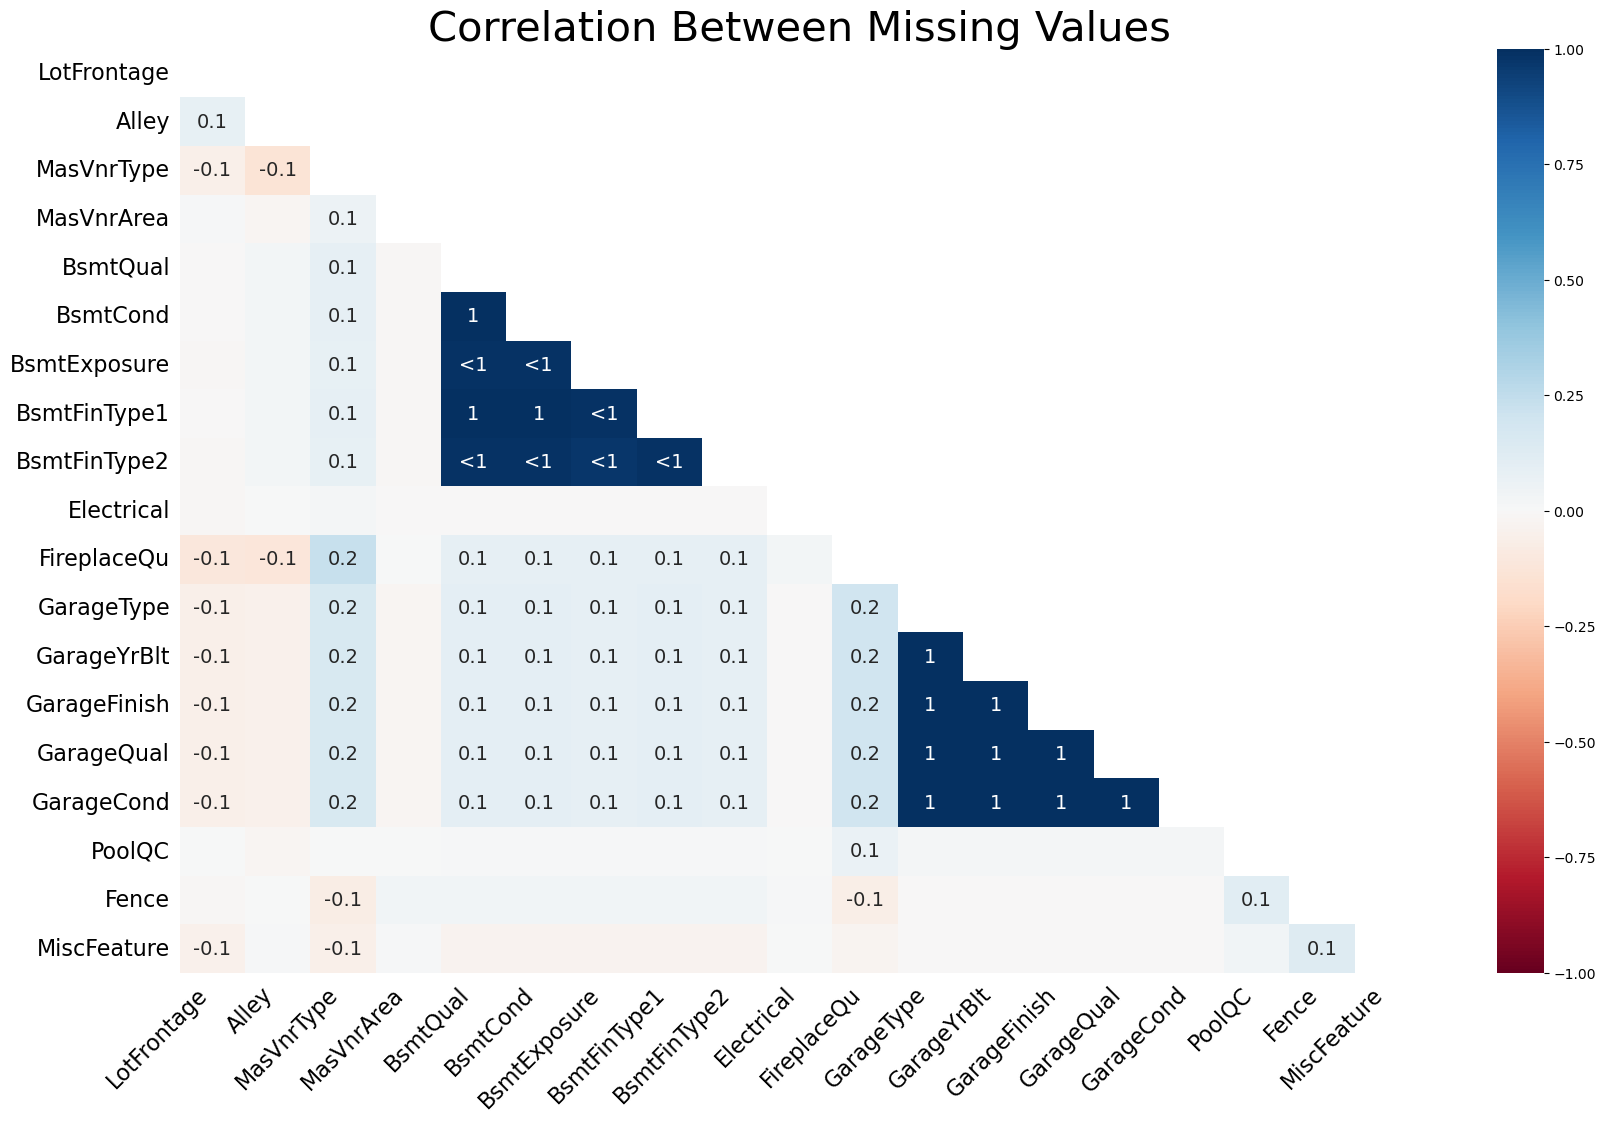

In [7]:
correlation_matrix_for_missing_values(TRAIN_DATA)
plt.show()

#### So as we can see from the heatmap, there is a strong correlation missing values between some columns. We can use this information to fill the missing values in the columns.

#### As we can see from the table 'LotFrontage' has no significant correlation with other columns. So we will impute the missing values in this column in next steps. (We can fill the missing values with KNN imputer, mean imputer, etc.)

#### 'GarageYrBlt' has a strong correlation with other columns about Garage. So we can use this information to fill the missing values in this column.

In [8]:
# find the 1 to 1 rules for the column GarageYrBlt in the TRAIN_DATA
find_every_1_to_1_rule(df=TRAIN_DATA,
                       numerical_columns=NUM_COLS,
                       categorical_columns=CAT_COLS,
                       head_column_name='GarageYrBlt',
                       body_column_name='GarageCond').head(6)

,Body_Name,Body_Value,Head_Name,Head_Value,Support,Confidence,Lift
0,GarageCond,TA,GarageYrBlt,Exists,0.908219,1.0,1.058738
1,GarageCond,Fa,GarageYrBlt,Exists,0.023973,1.0,1.058738
2,GarageCond,NaN,GarageYrBlt,NaN,0.055479,1.0,18.024691
3,GarageCond,Gd,GarageYrBlt,Exists,0.006164,1.0,1.058738
4,GarageCond,Po,GarageYrBlt,Exists,0.004795,1.0,1.058738
5,GarageCond,Ex,GarageYrBlt,Exists,0.001370,1.0,1.058738


What we can understand is that if 'GarageCond' is 'NaN', then it is normal that 'GarageYrBlt' is 'NaN' (confidence of the rule GarageCond = NaN -> GarageYrBlt = NaN is 1 in train set). <br>
However, we cannot leave it as 'NaN' so we choose to fill the missing values in 'GarageYrBlt' as 0 for train set. <br>
If in the test set, 'GarageCond' is 'NaN' and 'GarageYrBlt' is also 'NaN', then we can fill the missing values in 'GarageYrBlt' as 0. Otherwise, we have to impute its value by using a strategy (like KNN imputer, mean imputer, etc.) because when 'GarageCond' is not 'NaN', 'GarageYrBlt' is not 'NaN' (confidence of the rule GarageCond != NaN -> GarageYrBlt != NaN is almost 1). <br>

#### 'MasVnrArea' has a strong correlation with 'MasVnrType'. So we can use this information to fill the missing values in this column.

In [9]:
# find the 1 to 1 rules for the column MasVnrArea in the TRAIN_DATA
find_every_1_to_1_rule(df=TRAIN_DATA,
                       numerical_columns=NUM_COLS,
                       categorical_columns=CAT_COLS,
                       head_column_name='MasVnrArea',
                       body_column_name='MasVnrType').head(8)

,Body_Name,Body_Value,Head_Name,Head_Value,Support,Confidence,Lift
0,MasVnrType,BrkFace,MasVnrArea,Exists,0.304110,0.997753,2.464838
1,MasVnrType,BrkFace,MasVnrArea,Exists as 0,0.000685,0.002247,0.003811
2,MasVnrType,NaN,MasVnrArea,Exists,0.003425,0.005734,0.014165
3,MasVnrType,NaN,MasVnrArea,Exists as 0,0.588356,0.985092,1.670423
4,MasVnrType,NaN,MasVnrArea,NaN,0.005479,0.009174,1.674312
5,MasVnrType,Stone,MasVnrArea,Exists,0.086986,0.992188,2.451089
6,MasVnrType,Stone,MasVnrArea,Exists as 0,0.000685,0.007812,0.013248
7,MasVnrType,BrkCmn,MasVnrArea,Exists,0.010274,1.000000,2.470389


What we can understand is that if 'MasVnrType' is 'NaN', then 'MasVnrArea' should be 0 (confidence of the rule MasVnrType = NaN -> MasVnrArea = 0 is almost 1). <br>
We know that for train set, it is like that, but for test set, if 'MasVnrType' is not 'NaN' when 'MasVnrArea' is 'NaN', then we have to impute its value by using a strategy (like KNN imputer, mean imputer, etc.) because the confidence of the rules: <br>
- MasVnrType = BrkFace -> MasVnrArea > 0 (confidence is almost 1)
- MasVnrType = Stone -> MasVnrArea > 0 (confidence is almost 1)
- MasVnrType = BrkCmn -> MasVnrArea > 0 (confidence is 1) 


#### 'Electrical' has no strong correlation with other columns. So we will impute the missing values in this column in next steps. (We can fill the missing values with the most frequent value)

In [10]:
print(f"Most frequent value in 'Electrical' column: {TRAIN_DATA['Electrical'].mode()[0]}")

Most frequent value in 'Electrical' column: SBrkr


## 2- Imputation of Missing Values

In [11]:
NUMERICAL_IMPUTER = create_numerical_imputer(TRAIN_DATA, NUM_COLS)
CATEGORICAL_IMPUTER = create_categorical_imputer(TRAIN_DATA, CAT_COLS)

In [12]:
IMPUTED_TRAIN_DATA = TRAIN_DATA.copy()
IMPUTED_TRAIN_DATA.drop(columns=['Id'], inplace=True)
IMPUTED_TRAIN_DATA = IMPUTED_TRAIN_DATA.apply(lambda x: imputation_of_missing_values_in_row(x,
                                                                                            IMPUTED_TRAIN_DATA,
                                                                                            NUM_COLS,
                                                                                            CAT_COLS,
                                                                                            ALLOWED_NAN_COLUMNS,
                                                                                            NUMERICAL_IMPUTER,
                                                                                            CATEGORICAL_IMPUTER), axis=1)

# Data Analysis and Visualization

### 1- Showing some distributions of the columns to understand the data better

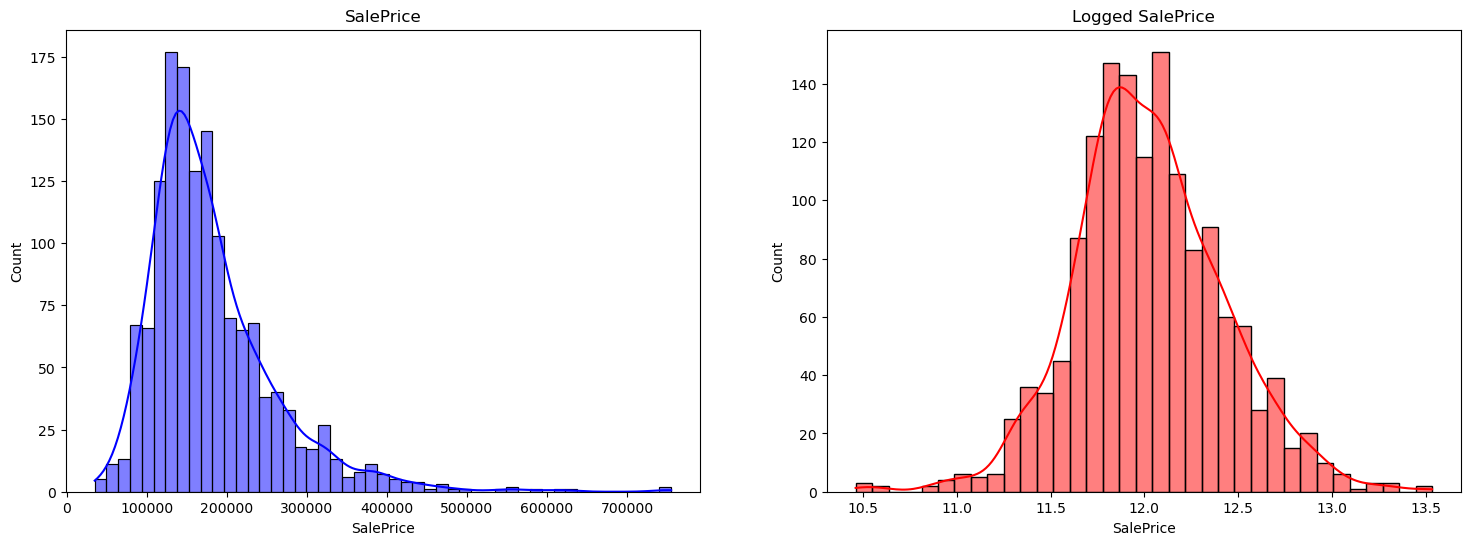

,count,mean,std,min,25%,50%,75%,max
SalePrice,1460.0,180921.196,79442.503,34900.0,129975.0,163000.0,214000.0,755000.0


In [13]:
# put normal and logged SalePrice side by side
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# show normal SalePrice distribution
sns.histplot(IMPUTED_TRAIN_DATA[TARGET_COLUMN], color='blue', kde=True, ax=ax[0])
ax[0].set_title("SalePrice")

# show logged SalePrice distribution
sns.histplot(np.log1p(IMPUTED_TRAIN_DATA[TARGET_COLUMN]), color='red', kde=True, ax=ax[1])
ax[1].set_title("Logged SalePrice")

plt.show()

# print descriptive statistics as table
pd.DataFrame(IMPUTED_TRAIN_DATA[TARGET_COLUMN].describe()).T.round(3)

### 2- Outlier Detection

In [14]:
# Refer to Outlier Analysis Notebook for reasoning (outlier_analysis.ipynb)
# Drop outliers
NO_OUT_TRAIN_DATA = IMPUTED_TRAIN_DATA.copy()

NO_OUT_TRAIN_DATA = NO_OUT_TRAIN_DATA[NO_OUT_TRAIN_DATA["LotArea"] < 100000]
NO_OUT_TRAIN_DATA = NO_OUT_TRAIN_DATA[NO_OUT_TRAIN_DATA["LotFrontage"] < 200]
NO_OUT_TRAIN_DATA = NO_OUT_TRAIN_DATA[NO_OUT_TRAIN_DATA["GrLivArea"] < 4500]
NO_OUT_TRAIN_DATA = NO_OUT_TRAIN_DATA[NO_OUT_TRAIN_DATA["MasVnrArea"] < 1500]
NO_OUT_TRAIN_DATA.reset_index(drop=True, inplace=True)

NO_OUT_TRAIN_DATA.shape

(1452, 80)

# Feature Engineering and Selection

## 1- Creating New Features

In [15]:
def add_features(df: pd.DataFrame,
                 numerical_cols: list[str],
                 categorical_cols: list[str]) -> Tuple[pd.DataFrame, list[str], list[str]]:
    """
    Adds new features to the dataframe
    
    :param df: dataframe to add new features
    :param numerical_cols: list of numerical columns in the dataframe
    :param categorical_cols: list of categorical columns in the dataframe
    :return: (dataframe with new features, updated list of numerical columns, updated list of categorical columns)
    """
    data = df.copy()
    num_cols = numerical_cols.copy()
    cat_cols = categorical_cols.copy()
    
    # sum of overall quality and overall condition
    data['overall cond-qual']      = data['OverallQual']  + data['OverallCond']
    num_cols.append('overall cond-qual')
    
    # age of the house when it was sold
    data['HouseAge']               = data['YrSold']       - data['YearBuilt']
    num_cols.append('HouseAge')
    
    # YearRemodAdd - YearBuilt means that how many years passed after the house got remodeled
    data['YearRemodAdd-YearBuilt'] = data['YearRemodAdd'] - data['YearBuilt']
    num_cols.append('YearRemodAdd-YearBuilt')
    
    # age of the remodeled house when it was sold
    data['RemodAge']               = data['YrSold']       - data['YearRemodAdd']
    num_cols.append('RemodAge')
    
    # sum of first and second floor square footage
    data['first-secondFlrSf']      = data['1stFlrSF']     + data['2ndFlrSF']
    num_cols.append('first-secondFlrSf')
    
    # total number of bathrooms in the basement
    data['BsmtBaths']              = data['BsmtFullBath'] + data['BsmtHalfBath'] * 0.5
    num_cols.append('BsmtBaths')
    
    # total number of bathrooms above the ground
    data['AboveBaths']             = data['FullBath']     + data['HalfBath'] * 0.5
    num_cols.append('AboveBaths')
    
    # total number of bathrooms in the house
    data['TotalBaths']             = data['BsmtBaths']    + data['AboveBaths']
    num_cols.append('TotalBaths')
    
    # total square footage of the porch
    data['PorchArea']              = data['OpenPorchSF']  + data['EnclosedPorch'] + \
                                     data['3SsnPorch']    + data['ScreenPorch']
    num_cols.append('PorchArea')
    
    # sum of total square footage of the basement, first floor, and second floor
    data['TotalSF']                = data['TotalBsmtSF']  + data['1stFlrSF'] + data['2ndFlrSF']
    num_cols.append('TotalSF')
    
    # inflation rate between 1850 and 2024, from https://www.officialdata.org/us/inflation/1850
    inflation_rates_df = pd.read_csv('data/inflation_rates.csv')
    
    # put YrSold inflation rates to the dataframe
    data = data.merge(inflation_rates_df.set_index('year'), left_on='YrSold', right_on='year', suffixes=('', '-sold'))
    num_cols.append('inflation_rate')
    
    # put built year inflation rates to the dataframe
    data = data.merge(inflation_rates_df.set_index('year'), left_on='YearBuilt', right_on='year', suffixes=('', '-built'))
    num_cols.append('inflation_rate-built')
    
    # put remodeled year inflation rates to the dataframe
    data = data.merge(inflation_rates_df.set_index('year'), left_on='YearRemodAdd', right_on='year', suffixes=('', '-remod'))
    num_cols.append('inflation_rate-remod')
    
    # calculate cumulative inflation rate between YearBuilt and YrSold
    data['cum-inflation-rate'] = data.apply(lambda x: calculate_cum_inflation_rate(x['YearBuilt'], x['YrSold'], inflation_rates_df), axis=1)
    num_cols.append('cum-inflation-rate')
    
    return data, num_cols, cat_cols

In [16]:
DATA, NUM_COLS_EXTRA, CATEGORICAL_COLUMNS_EXTRA = add_features(NO_OUT_TRAIN_DATA, NUM_COLS, CAT_COLS)

# put SalePrice at the end of the dataframe
DATA = DATA[[COLUMN for COLUMN in DATA.columns if COLUMN != TARGET_COLUMN] + [TARGET_COLUMN]]

DATA

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,BsmtBaths,AboveBaths,TotalBaths,PorchArea,TotalSF,inflation_rate,inflation_rate-built,inflation_rate-remod,cum-inflation-rate,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,1.0,2.5,3.5,61,2566,0.04,0.02,0.02,19.393975,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.5,2.0,2.5,0,2524,0.03,0.06,0.06,285.839239,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,1.0,2.5,3.5,42,2706,0.04,0.03,0.02,25.435310,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,1.0,1.0,2.0,307,2473,0.03,0.01,0.06,1888.676071,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,1.0,2.5,3.5,84,3343,0.04,0.03,0.03,29.198369,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,2.5,2.5,40,2600,0.03,0.02,0.03,26.713785,175000
1448,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,1.0,2.0,3.0,0,3615,0.02,0.08,0.04,260.869569,210000
1449,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,2.0,2.0,60,3492,0.02,0.05,0.03,1453.695438,266500
1450,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,1.0,1.0,2.0,112,2156,0.02,0.01,0.03,818.247696,142125


## 3- One-Hot Encoding

In [17]:
ONE_HOT_DATA = pd.get_dummies(DATA)

CAT_COLS_EXTRA_ONE_HOT = ONE_HOT_DATA.columns.tolist() # get the columns of the one-hot encoded data
CAT_COLS_EXTRA_ONE_HOT = [COLUMN for COLUMN in CAT_COLS_EXTRA_ONE_HOT if COLUMN not in NUM_COLS_EXTRA]
CAT_COLS_EXTRA_ONE_HOT.remove(TARGET_COLUMN) # remove SalePrice column

# put SalePrice at the end of the dataframe
ONE_HOT_DATA = ONE_HOT_DATA[[COLUMN for COLUMN in ONE_HOT_DATA.columns if COLUMN != TARGET_COLUMN] + [TARGET_COLUMN]]

ONE_HOT_DATA

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,False,False,True,False,False,False,False,True,False,208500
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,False,False,True,False,False,False,False,True,False,181500
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,False,False,True,False,False,False,False,True,False,223500
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,...,False,False,True,True,False,False,False,False,False,140000
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,False,False,True,False,False,False,False,True,False,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,62.0,7917,6,5,1999,2000,0.0,0,0,953,...,False,False,True,False,False,False,False,True,False,175000
1448,85.0,13175,6,6,1978,1988,119.0,790,163,589,...,False,False,True,False,False,False,False,True,False,210000
1449,66.0,9042,7,9,1941,2006,0.0,275,0,877,...,False,False,True,False,False,False,False,True,False,266500
1450,68.0,9717,5,6,1950,1996,0.0,49,1029,0,...,False,False,True,False,False,False,False,True,False,142125


- categorical visualization, and so on... (Kaja will do this part)
- encode the data one-hot (done)
- pca to eliminate multi-collinearity (Alice)
- arm with categorical features (done) (we will this step after pca because having correlated lots of correlated features will make the rules unimportant, so we will eliminate the correlated features first and then find the rules with arm)
- showing importance of the features with lasso or random forest (or both) (cross-validation)
- we will have 3 types of data: ONE_HOT_DATA (no elimination or PCA applied), PCA_DATA (one-hot as well, pca applied), ELIMINATED_WITH_LASSO (one-hot as well, pca and lasso applied), ELIMINATED_WITH_RF (one-hot as well, pca and random forest applied)
- Train the models:
- 1. Linear Regression
- ...

### 2- PCA to Eliminate Multi-Collinearity
#### You can use ONE_HOT_FINAL_TRAIN_DATA for this step

In [18]:
# IMPORTANT: CHANGE THIS AFTER
PCA_DATA = ONE_HOT_DATA.copy()
NUM_COLS_PCA = NUM_COLS_EXTRA.copy()
CAT_COLS_PCA_ONE_HOT = CAT_COLS_EXTRA_ONE_HOT.copy()
PCA_DATA

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,False,False,True,False,False,False,False,True,False,208500
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,False,False,True,False,False,False,False,True,False,181500
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,False,False,True,False,False,False,False,True,False,223500
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,...,False,False,True,True,False,False,False,False,False,140000
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,False,False,True,False,False,False,False,True,False,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,62.0,7917,6,5,1999,2000,0.0,0,0,953,...,False,False,True,False,False,False,False,True,False,175000
1448,85.0,13175,6,6,1978,1988,119.0,790,163,589,...,False,False,True,False,False,False,False,True,False,210000
1449,66.0,9042,7,9,1941,2006,0.0,275,0,877,...,False,False,True,False,False,False,False,True,False,266500
1450,68.0,9717,5,6,1950,1996,0.0,49,1029,0,...,False,False,True,False,False,False,False,True,False,142125


## 3- ARM to Find Association Rules

In [19]:
PCA_DATA[CAT_COLS_PCA_ONE_HOT]

,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False
1,False,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False
1448,False,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
1449,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
1450,False,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [20]:
# Find frequent item sets by just using categorical columns
FREQ_ITEM_SETS = apriori(PCA_DATA[CAT_COLS_PCA_ONE_HOT], min_support=0.8, use_colnames=True, max_len=2)

# Find association rules
ASSOC_RULES = association_rules(FREQ_ITEM_SETS, metric='confidence', min_threshold=0.8, num_itemsets=len(FREQ_ITEM_SETS))

ASSOC_RULES[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
0,(Alley_NaN),(Street_Pave),0.934573,0.996329,0.999772
1,(Street_Pave),(Alley_NaN),0.934573,0.937802,0.999772
2,(LandContour_Lvl),(Street_Pave),0.900826,0.998473,1.001923
3,(Street_Pave),(LandContour_Lvl),0.900826,0.903939,1.001923
4,(Street_Pave),(Utilities_AllPub),0.995868,0.999309,0.999998
...,...,...,...,...,...
399,(SaleType_WD),(PoolQC_NaN),0.864325,0.995242,0.999372
400,(PoolQC_NaN),(SaleCondition_Normal),0.818871,0.822268,1.001622
401,(SaleCondition_Normal),(PoolQC_NaN),0.818871,0.997483,1.001622
402,(MiscFeature_NaN),(SaleType_WD),0.836088,0.867143,0.998486


In [21]:
# Filter rules with lift greater than 1
STRONG_ASSOC_RULES = ASSOC_RULES[ASSOC_RULES['lift'] > 1]
STRONG_ASSOC_RULES = STRONG_ASSOC_RULES.sort_values(by='lift', ascending=False)
STRONG_ASSOC_RULES.reset_index(drop=True, inplace=True)

STRONG_ASSOC_RULES

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(GarageQual_TA),(GarageCond_TA),0.897383,0.907713,0.883609,0.984651,1.084759,1.0,0.069042,6.012466,0.761439,0.958894,0.833679,0.979048
1,(GarageCond_TA),(GarageQual_TA),0.907713,0.897383,0.883609,0.973445,1.084759,1.0,0.069042,3.864266,0.846675,0.958894,0.741219,0.979048
2,(LandSlope_Gtl),(LandContour_Lvl),0.949725,0.902204,0.890496,0.937636,1.039273,1.0,0.033651,1.568150,0.751634,0.926218,0.362306,0.962329
3,(LandContour_Lvl),(LandSlope_Gtl),0.902204,0.949725,0.890496,0.987023,1.039273,1.0,0.033651,3.874170,0.386403,0.926218,0.741880,0.962329
4,(GarageCond_TA),(PavedDrive_Y),0.907713,0.917355,0.862259,0.949924,1.035503,1.0,0.029563,1.650388,0.371513,0.895565,0.394082,0.944932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,(Street_Pave),(SaleCondition_Normal),0.996556,0.820937,0.818182,0.821009,1.000088,1.0,0.000072,1.000404,0.025589,0.818746,0.000404,0.908827
264,(Condition2_Norm),(BsmtFinType2_Unf),0.990358,0.860882,0.852617,0.860918,1.000042,1.0,0.000036,1.000262,0.004385,0.853793,0.000262,0.925659
265,(BsmtFinType2_Unf),(Condition2_Norm),0.860882,0.990358,0.852617,0.990400,1.000042,1.0,0.000036,1.004362,0.000304,0.853793,0.004343,0.925659
266,(ExterCond_TA),(LandSlope_Gtl),0.877410,0.949725,0.833333,0.949765,1.000042,1.0,0.000035,1.000796,0.000344,0.838531,0.000796,0.913606


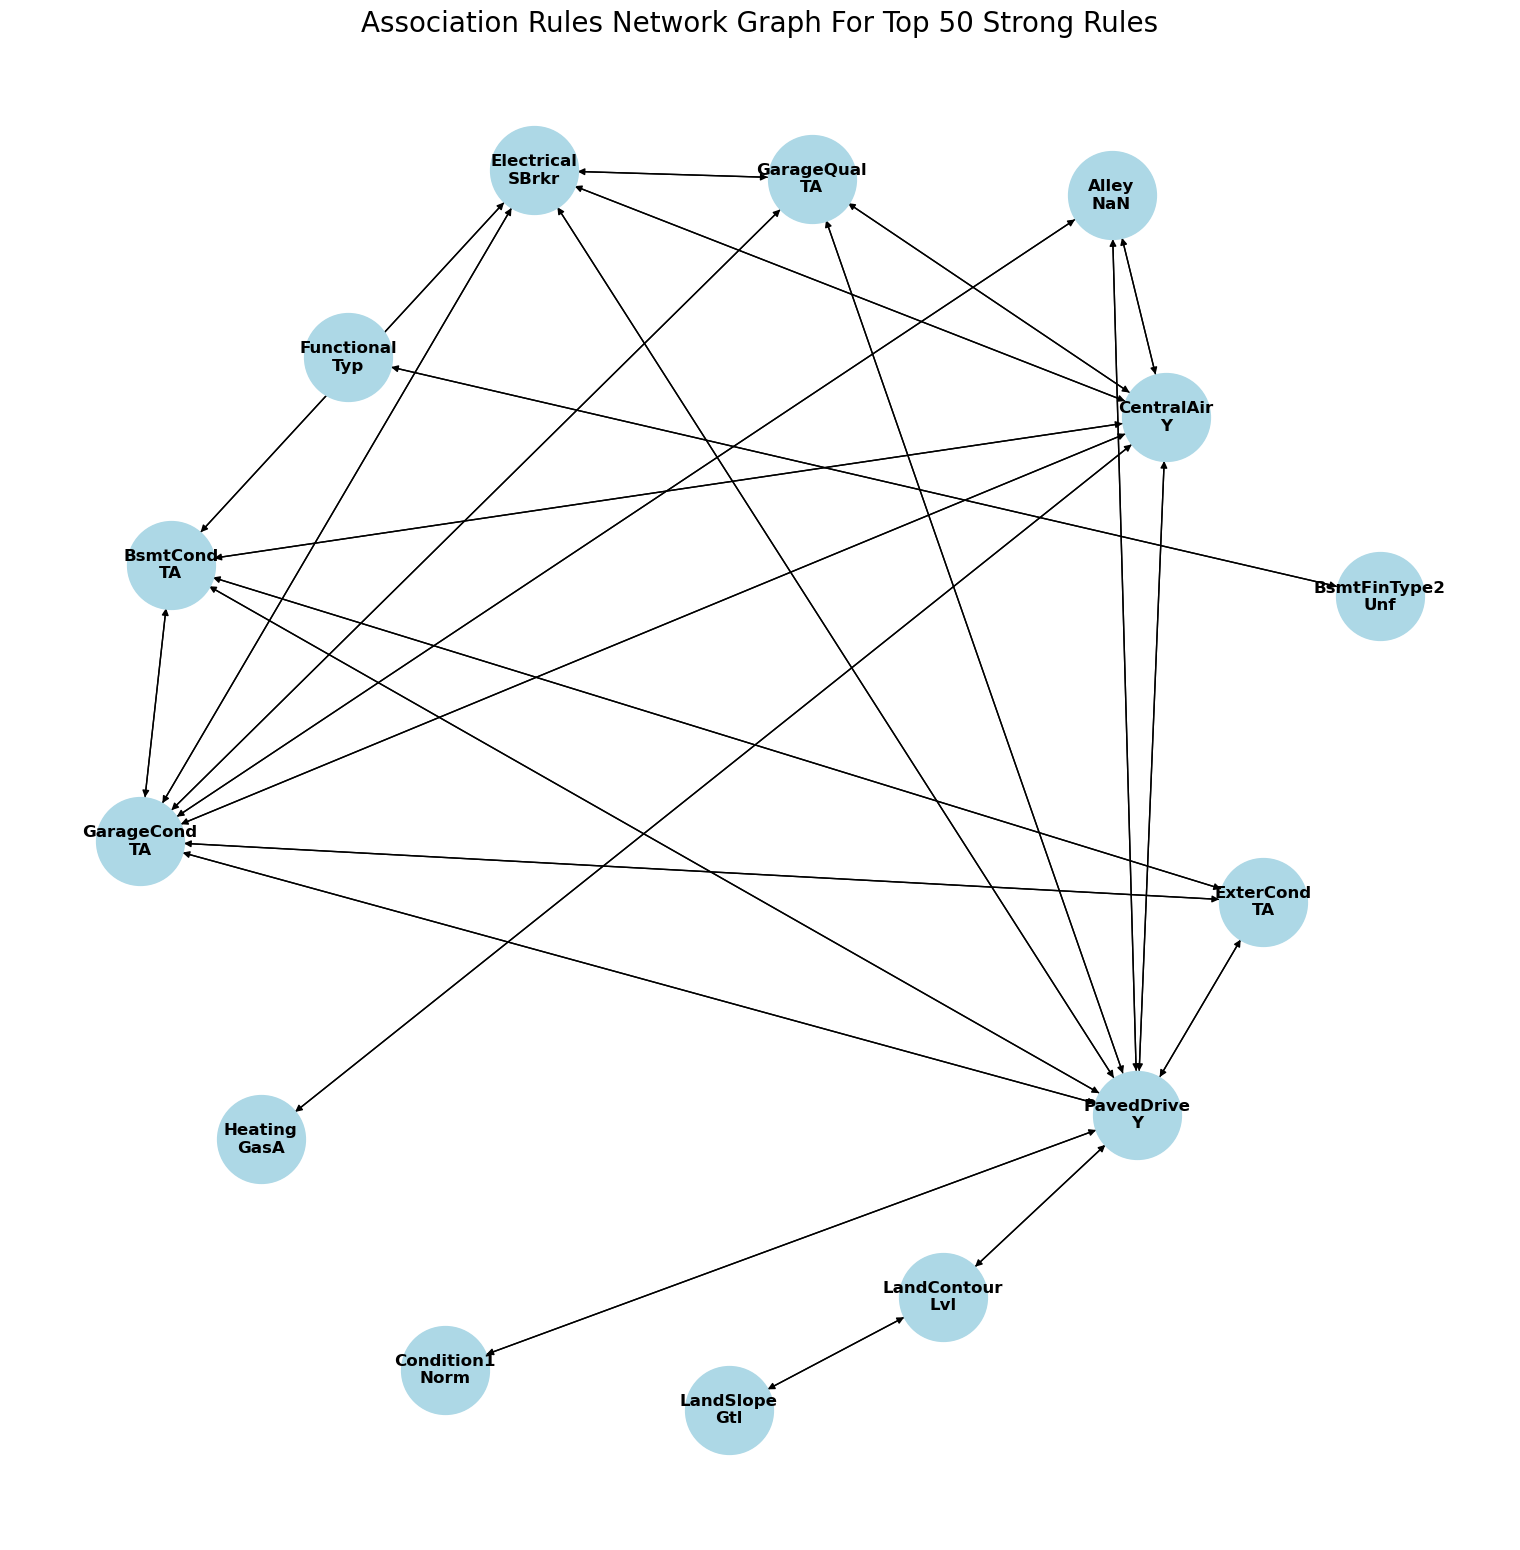

In [22]:
# Visualize Rules
import networkx as nx

GRAPH_RULES = STRONG_ASSOC_RULES.copy().head(50)

# make all antecedents and consequents as string
GRAPH_RULES['antecedents'] = GRAPH_RULES['antecedents'].apply(lambda x: ', '.join(list(x)))
GRAPH_RULES['consequents'] = GRAPH_RULES['consequents'].apply(lambda x: ', '.join(list(x)))

# and before last _, add \n to split the string, not every _ just the last one
GRAPH_RULES['antecedents'] = GRAPH_RULES['antecedents'].apply(lambda x: x.rsplit('_', 1)[0] + '\n' + x.rsplit('_', 1)[1])
GRAPH_RULES['consequents'] = GRAPH_RULES['consequents'].apply(lambda x: x.rsplit('_', 1)[0] + '\n' + x.rsplit('_', 1)[1])

# Create a graph
G = nx.from_pandas_edgelist(
    df=GRAPH_RULES,
    source='antecedents',
    target='consequents',
    edge_attr=True,
    create_using=nx.DiGraph
)

# Draw the graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=4, seed=1)
nx.draw(G, pos, node_size=4000, node_color='lightblue', font_size=12, font_weight='bold', arrows=True, with_labels=True, arrowstyle='-|>')
plt.title('Association Rules Network Graph For Top 50 Strong Rules', size=20)
plt.show()


## 3- Random Forest for Feature Selection

In [23]:
# Target variables and feature set
y = PCA_DATA[TARGET_COLUMN]
X = PCA_DATA.drop([TARGET_COLUMN], axis=1)

# Split into training and validation sets
X_TRAIN, X_VAL, y_TRAIN, y_VAL = train_test_split(X, y, test_size=0.2, random_state=42)
X_TRAIN

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1262,78.000000,11344,5,5,1958,1958,180.0,460,0,414,...,False,False,False,True,False,False,False,False,True,False
979,59.000000,5310,6,8,1910,2003,0.0,0,0,485,...,False,False,False,True,False,False,False,False,True,False
792,104.000000,13518,9,5,2008,2009,860.0,0,0,1926,...,False,True,False,False,False,False,False,False,False,True
1433,70.049958,4426,6,5,2004,2004,147.0,697,0,151,...,False,False,False,True,False,False,False,False,True,False
374,88.000000,11394,9,2,2010,2010,350.0,1445,0,411,...,False,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,70.000000,7000,5,7,1960,2002,45.0,588,0,422,...,False,False,False,True,False,False,False,True,False,False
1130,54.000000,6342,5,8,1875,1996,0.0,0,0,780,...,False,False,False,True,False,False,False,False,True,False
1294,92.000000,10120,8,5,1994,1994,391.0,740,0,425,...,False,False,False,True,False,False,False,False,True,False
860,67.000000,10656,8,5,2006,2007,274.0,0,0,1638,...,False,True,False,False,False,False,False,False,False,True


In [24]:
# Normalize numerical data
NUMERICAL_TRANSFORMER = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
PREPROCESSOR = ColumnTransformer(
    transformers=[
        ('num', NUMERICAL_TRANSFORMER, NUM_COLS_EXTRA),
        ('cat', NUMERICAL_TRANSFORMER, CAT_COLS_EXTRA_ONE_HOT)        
    ]
)

In [25]:
RF_PIPELINE = Pipeline(steps=[
    ('preprocessor', PREPROCESSOR),
    ('regressor', RandomForestRegressor(random_state=42, n_estimators=500))
])

RF_PARAM_GRID = {}

RF_GRID_SEARCH = GridSearchCV(
    estimator=RF_PIPELINE,
    param_grid=RF_PARAM_GRID,
    scoring='neg_mean_squared_error',
    cv=5
)

RF_GRID_SEARCH.fit(X_TRAIN, np.log1p(y_TRAIN))

RF_SEARCH_BEST_PARAMS = RF_GRID_SEARCH.best_params_
RF_SEARCH_BEST_SCORE_RF = -RF_GRID_SEARCH.best_score_

print(f"Best parameters: {RF_SEARCH_BEST_PARAMS}")
print(f"Best CV MSE: {RF_SEARCH_BEST_SCORE_RF}")

Best parameters: {}
Best CV MSE: 0.019250256324779138


In [26]:
RF_BEST_PARAMS = {}
for KEY, VALUE in RF_SEARCH_BEST_PARAMS.items():
    RF_BEST_PARAMS[KEY.split('__')[1]] = VALUE

# Fit the model to the data
RF_BEST_MODEL = Pipeline(steps=[
    ('preprocessor', PREPROCESSOR),
    ('regressor', RandomForestRegressor(random_state=42, n_estimators=500, **RF_BEST_PARAMS))
])
RF_BEST_MODEL.fit(X_TRAIN, np.log1p(y_TRAIN))

# Model performance
y_VAL_PRED = RF_BEST_MODEL.predict(X_VAL)

print("Random Forest Model Performance:")
print(f"Validation MSE: {mean_squared_error(y_VAL, np.expm1(y_VAL_PRED))}")
print(f"Validation RMSE: {root_mean_squared_error(y_VAL, np.expm1(y_VAL_PRED))}")
print(f"Validation MAPE: {mean_absolute_percentage_error(y_VAL, np.expm1(y_VAL_PRED))}")
print(f"Validation R^2 Score: {r2_score(y_VAL, np.expm1(y_VAL_PRED))}")

Random Forest Model Performance:
Validation MSE: 557165200.3829453
Validation RMSE: 23604.347065380676
Validation MAPE: 0.09924866657526957
Validation R^2 Score: 0.8908170047473747


Number of non-zero importance features: 169


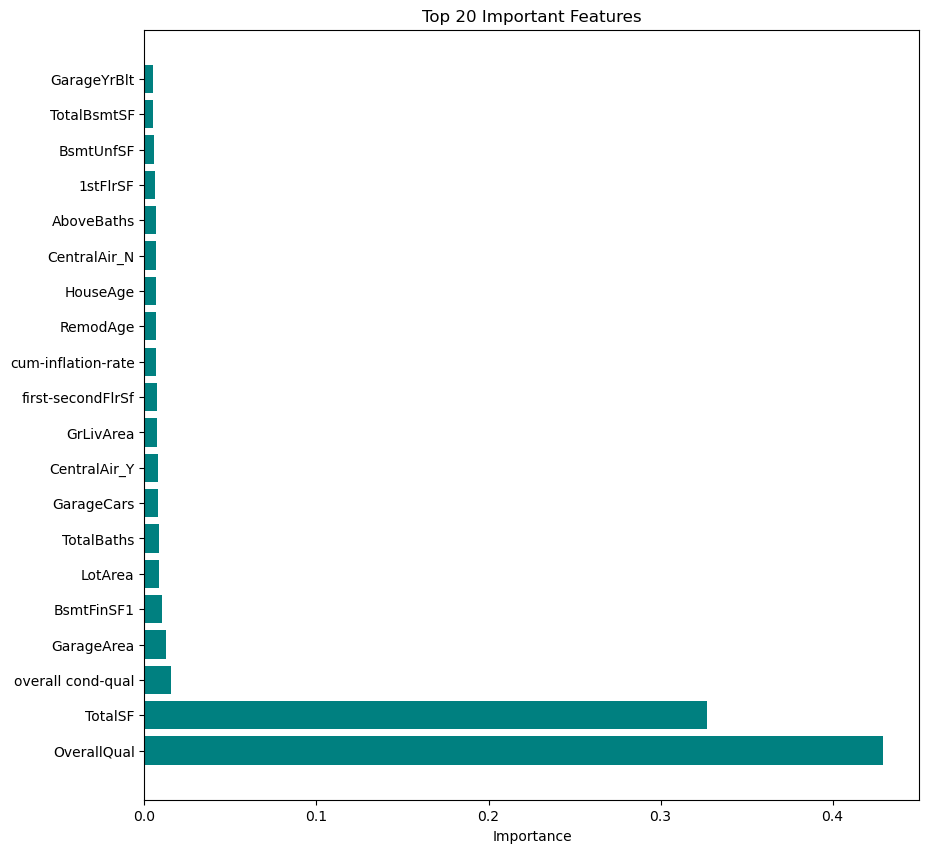

In [27]:
# Get the importance of the resulting features
# Create a data frame for visualization
RF_FEATURE_IMPORTANCE = pd.DataFrame({'Features': X.columns, 'Importances': RF_BEST_MODEL.named_steps['regressor'].feature_importances_})
RF_FEATURE_IMPORTANCE = RF_FEATURE_IMPORTANCE.sort_values(by='Importances', ascending=False)
RF_FEATURE_IMPORTANCE.reset_index(drop=True, inplace=True)

# Eliminate features with zero importance
RF_NON_ZERO_FEATURES_DF = RF_FEATURE_IMPORTANCE[RF_FEATURE_IMPORTANCE['Importances'] > 10e-5]
RF_NON_ZERO_FEATURES_DF = RF_NON_ZERO_FEATURES_DF.sort_values(by='Importances', ascending=False)
RF_NON_ZERO_FEATURES_DF.reset_index(drop=True, inplace=True)
print(f"Number of non-zero importance features: {RF_NON_ZERO_FEATURES_DF.shape[0]}")

plt.figure(figsize=(10, 10))
plt.title(f"Top 20 Important Features")
plt.xlabel('Importance')
plt.barh(RF_NON_ZERO_FEATURES_DF['Features'][0:20], RF_NON_ZERO_FEATURES_DF['Importances'][0:20], color='teal')
plt.show()

## 4- Lasso for Feature Selection

In [28]:
# Lasso and preprocessing pipeline
LASSO_PIPELINE = Pipeline(steps=[
    ('preprocessor', PREPROCESSOR),
    ('lasso', Lasso(random_state=42))
])

# Parameter grid for alpha
LASSO_PARAM_GRID = {
    # From 0.0001 to 100
    'lasso__alpha': np.logspace(-4, 4, 100)
}

LASSO_GRID_SEARCH = GridSearchCV(
    estimator=LASSO_PIPELINE,
    param_grid=LASSO_PARAM_GRID,
    scoring='neg_mean_squared_error',
    cv=5,
)
LASSO_GRID_SEARCH.fit(X_TRAIN, np.log1p(y_TRAIN))

# Get best alpha value and score
LASSO_SEARCH_BEST_PARAMS = LASSO_GRID_SEARCH.best_params_
LASSO_SEARCH_BEST_SCORE = -LASSO_GRID_SEARCH.best_score_

print("Best parameters: ", LASSO_SEARCH_BEST_PARAMS)
print("Best CV MSE: ", LASSO_SEARCH_BEST_SCORE)

Best parameters:  {'lasso__alpha': 0.003430469286314919}
Best CV MSE:  0.01207013268936282


In [29]:
LASSO_BEST_PARAMS = {}
for KEY, VALUE in LASSO_SEARCH_BEST_PARAMS.items():
    LASSO_BEST_PARAMS[KEY.split('__')[1]] = VALUE

# Fit LASSO Regression Model with Best Alpha
LASSO_BEST = Pipeline(steps=[
    ('preprocessor', PREPROCESSOR),
    ('regressor', Lasso(random_state=42, **LASSO_BEST_PARAMS))
])
LASSO_BEST.fit(X_TRAIN, np.log1p(y_TRAIN))

# Model performance
y_VAL_PRED = LASSO_BEST.predict(X_VAL)

print("Lasso Model Performance:")
print(f"Validation MSE: {mean_squared_error(y_VAL, np.expm1(y_VAL_PRED))}")
print(f"Validation RMSE: {root_mean_squared_error(y_VAL, np.expm1(y_VAL_PRED))}")
print(f"Validation MAPE: {mean_absolute_percentage_error(y_VAL, np.expm1(y_VAL_PRED))}")
print(f"Validation R^2 Score: {r2_score(y_VAL, np.expm1(y_VAL_PRED))}")

Lasso Model Performance:
Validation MSE: 389420054.97960985
Validation RMSE: 19733.728866577898
Validation MAPE: 0.08303065331254784
Validation R^2 Score: 0.9236886151811119


Number of non-zero importance features: 117


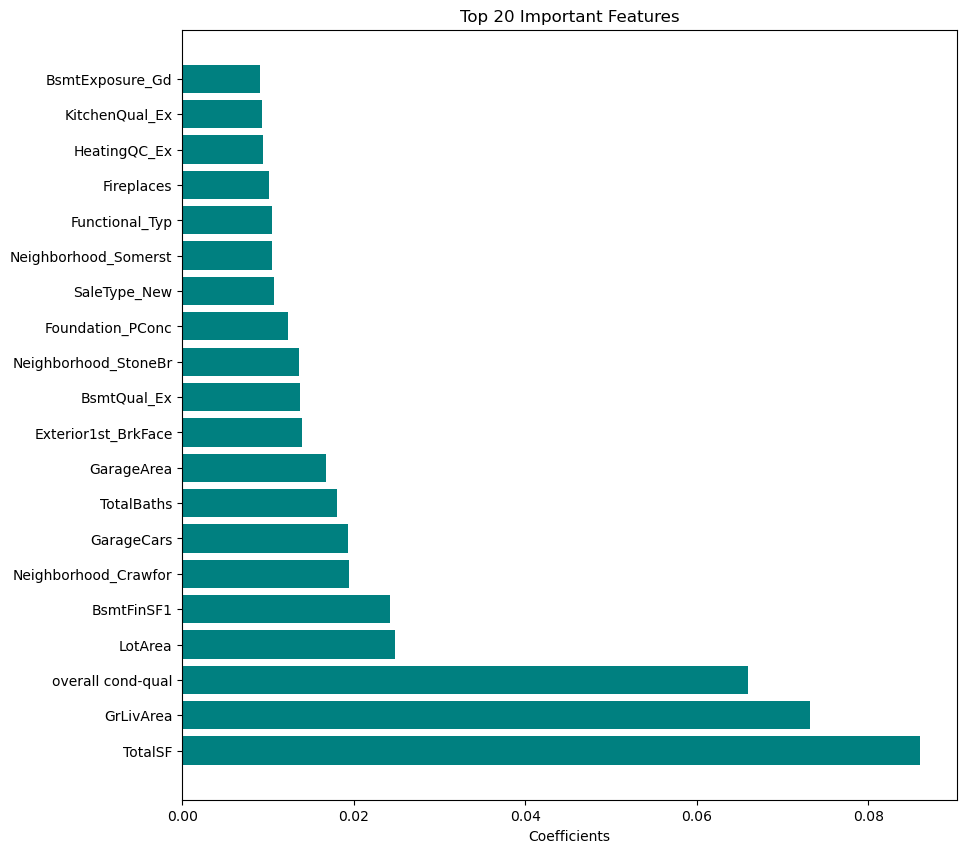

In [30]:
# get the importance of the resulting features
# Create a data frame for visualization
LASSO_FEATURE_IMPORTANCE = pd.DataFrame({'Features': X.columns, 'Coefficients': LASSO_BEST.named_steps['regressor'].coef_})
LASSO_FEATURE_IMPORTANCE = LASSO_FEATURE_IMPORTANCE.sort_values(by='Coefficients', ascending=False)
LASSO_FEATURE_IMPORTANCE.reset_index(drop=True, inplace=True)

# Eliminate features with zero importance
LASSO_NON_ZERO_FEATURES_DF = LASSO_FEATURE_IMPORTANCE[LASSO_FEATURE_IMPORTANCE['Coefficients'] != 0]
LASSO_NON_ZERO_FEATURES_DF = LASSO_NON_ZERO_FEATURES_DF.sort_values(by='Coefficients', ascending=False)
LASSO_NON_ZERO_FEATURES_DF.reset_index(drop=True, inplace=True)
print(f"Number of non-zero importance features: {LASSO_NON_ZERO_FEATURES_DF.shape[0]}")

plt.figure(figsize=(10, 10))
plt.title(f"Top 20 Important Features")
plt.xlabel('Coefficients')
plt.barh(LASSO_NON_ZERO_FEATURES_DF['Features'][0:20], LASSO_NON_ZERO_FEATURES_DF['Coefficients'][0:20], color='teal')
plt.show()

# Model Selection and Training

#### (We can first try a simple models like linear regression, decision tree, random forest, etc. and then we can try ensemble models like XGBoost, LightGBM, etc.)

# Testing and Evaluation

## 1- Imputation of Missing Values in Test Data

In [31]:
IMPUTED_TEST_DATA = TEST_DATA.copy()
IMPUTED_TEST_DATA.drop(columns=['Id'], inplace=True)

# fill the missing values in the test data by using the rules that we found in the train data and the imputers that we created by using the train data
IMPUTED_TEST_DATA = IMPUTED_TEST_DATA.apply(lambda x: imputation_of_missing_values_in_row(row=x,
                                                                                          train_data=IMPUTED_TRAIN_DATA,
                                                                                          numerical_columns=NUM_COLS,
                                                                                          categorical_columns=CAT_COLS,
                                                                                          allowed_nan_columns=ALLOWED_NAN_COLUMNS,
                                                                                          numerical_imputer=NUMERICAL_IMPUTER,
                                                                                          categorical_imputer=CATEGORICAL_IMPUTER), axis=1)
IMPUTED_TEST_DATA = add_features(IMPUTED_TEST_DATA, NUM_COLS, CAT_COLS)[0]

## 2- Model Testing and Comparison

## 3- Conclusion